## DSI - Project 5 - Andy

### Dataset

https://www.kaggle.com/datasets/abeperez/historical-plane-crash-data

### Problem Statement

As an airplane fan, it is both my personal and public attention about the air travel safety. Although air travel is one of the safest transportation nowadays, the risk still exist, especially the high injury and mortality rate when single accident occurred. In order to help publics to understand more about the plane crashes, this study utilizes the historical airplane crash records and explores the major causes of airplane crashes like occurring time, occurring flight phase, aircraft type, operator, and crash site.

### 1. Load the Data

In [192]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  RandomForestClassifier

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

In [193]:
df_crash = pd.read_csv('data/plane_crash_data.csv', encoding= 'unicode_escape')

### 2. Data Cleaning

In [194]:
df_crash.shape

(28440, 24)

In [195]:
df_crash.columns

Index(['Date', 'Time', 'Aircraft', 'Operator', 'Registration', 'Flight phase',
       'Flight type', 'Survivors', 'Crash site', 'Schedule', 'MSN', 'YOM',
       'Flight no.', 'Crash location', 'Country', 'Region', 'Crew on board',
       'Crew fatalities', 'Pax on board', 'PAX fatalities', 'Other fatalities',
       'Total fatalities', 'Circumstances', 'Crash cause'],
      dtype='object')

In [196]:
df_crash.head(2)

,Date,Time,Aircraft,Operator,Registration,Flight phase,Flight type,Survivors,Crash site,Schedule,...,Country,Region,Crew on board,Crew fatalities,Pax on board,PAX fatalities,Other fatalities,Total fatalities,Circumstances,Crash cause
0,1918-05-02,NaN,De Havilland DH.4,United States Signal Corps - USSC,AS-32084,Takeoff (climb),Test,No,Airport (less than 10 km from airport),Dayton - Dayton,...,United States of America,North America,2.0,2.0,0.0,0.0,0.0,2,The single engine airplane departed Dayton-McC...,Technical failure
1,1918-06-08,NaN,Handley Page V/1500,Handley Page Aircraft Company Ltd,E4104,Takeoff (climb),Test,Yes,Airport (less than 10 km from airport),Cricklewood - Cricklewood,...,United Kingdom,Europe,6.0,5.0,0.0,0.0,0.0,5,"Assembled at Cricklewood Airfield in May 1918,...",Technical failure


In [197]:
df_crash.isnull().sum()

Date                    0
Time                14546
Aircraft                1
Operator                0
Registration          813
Flight phase          639
Flight type            57
Survivors            1304
Crash site            382
Schedule             8959
MSN                  4171
YOM                  5321
Flight no.          25602
Crash location         13
Country                 1
Region                  1
Crew on board          24
Crew fatalities         1
Pax on board           54
PAX fatalities          1
Other fatalities       10
Total fatalities        0
Circumstances          25
Crash cause             0
dtype: int64

In [198]:
# Remove columns that are either with too many missing values or not part of the study
df_crash = df_crash.drop(columns = ['Time', 'Registration', 'Flight no.', 'Schedule', 'MSN', 'YOM', 'Crew on board', 'Crew fatalities', 
                                    'Pax on board', 'PAX fatalities', 'Other fatalities'])

In [199]:
df_crash.isna().sum()

Date                   0
Aircraft               1
Operator               0
Flight phase         639
Flight type           57
Survivors           1304
Crash site           382
Crash location        13
Country                1
Region                 1
Total fatalities       0
Circumstances         25
Crash cause            0
dtype: int64

In [200]:
df_crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28440 entries, 0 to 28439
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date              28440 non-null  object
 1   Aircraft          28439 non-null  object
 2   Operator          28440 non-null  object
 3   Flight phase      27801 non-null  object
 4   Flight type       28383 non-null  object
 5   Survivors         27136 non-null  object
 6   Crash site        28058 non-null  object
 7   Crash location    28427 non-null  object
 8   Country           28439 non-null  object
 9   Region            28439 non-null  object
 10  Total fatalities  28440 non-null  int64 
 11  Circumstances     28415 non-null  object
 12  Crash cause       28440 non-null  object
dtypes: int64(1), object(12)
memory usage: 2.8+ MB


Survivors will the y in later model. so I removed all missing values in this column.

In [201]:
df_crash = df_crash.dropna(subset = ['Survivors'])

In [202]:
# Convert y value into numeric
survive_dumy = pd.get_dummies(df_crash['Survivors'])
df_crash['survive'] = survive_dumy['Yes']
df_crash = df_crash.drop(columns = ['Survivors'])
df_crash.head()

,Date,Aircraft,Operator,Flight phase,Flight type,Crash site,Crash location,Country,Region,Total fatalities,Circumstances,Crash cause,survive
0,1918-05-02,De Havilland DH.4,United States Signal Corps - USSC,Takeoff (climb),Test,Airport (less than 10 km from airport),Dayton-McCook Field Ohio,United States of America,North America,2,The single engine airplane departed Dayton-McC...,Technical failure,0
1,1918-06-08,Handley Page V/1500,Handley Page Aircraft Company Ltd,Takeoff (climb),Test,Airport (less than 10 km from airport),Cricklewood London Metropolis,United Kingdom,Europe,5,"Assembled at Cricklewood Airfield in May 1918,...",Technical failure,1
2,1918-06-11,Avro 504,Royal Air Force - RAF,Flight,Training,"Plain, Valley",Abukir (Abu Qir) Alexandria,Egypt,Africa,1,The single engine aircraft was completing a lo...,Unknown,1
3,1918-06-19,De Havilland DH.4,United States Signal Corps - USSC,Flight,Military,Airport (less than 10 km from airport),Wright-Patterson AFB (Dayton) Ohio,United States of America,North America,1,"Lt. Frank Stuart Patterson, son and nephew of ...",Technical failure,0
4,1918-06-24,Breguet 14,French Air Force - Armée de l'Air,Landing (descent or approach),Military,NaN,France All France,France,Europe,0,The aircraft crashed iupon landing somewhere i...,Unknown,1


In [203]:
df_crash.shape

(27136, 13)

### 3. EDA

Checking flight time since the purpose of the study is commercial air travel.

In [204]:
df_crash['Flight type'].value_counts()

Scheduled Revenue Flight                       5633
Military                                       4149
Training                                       3188
Cargo                                          2784
Private                                        2244
Charter/Taxi (Non Scheduled Revenue Flight)    1803
Executive/Corporate/Business                   1030
Survey / Patrol / Reconnaissance                875
Bombing                                         673
Positioning                                     669
Test                                            546
Postal (mail)                                   473
Spraying (Agricultural)                         450
Ferry                                           421
Supply                                          406
Ambulance                                       226
Government                                      224
Illegal (smuggling)                             220
Delivery                                        177
Demonstratio

In [205]:
# Convert the date into datetime series, not sure if it's necessary at this point
df_crash['Date'] = pd.to_datetime(df_crash['Date'])

In [206]:
df_crash.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27136 entries, 0 to 28439
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              27136 non-null  datetime64[ns]
 1   Aircraft          27136 non-null  object        
 2   Operator          27136 non-null  object        
 3   Flight phase      26903 non-null  object        
 4   Flight type       27099 non-null  object        
 5   Crash site        27036 non-null  object        
 6   Crash location    27124 non-null  object        
 7   Country           27135 non-null  object        
 8   Region            27135 non-null  object        
 9   Total fatalities  27136 non-null  int64         
 10  Circumstances     27121 non-null  object        
 11  Crash cause       27136 non-null  object        
 12  survive           27136 non-null  uint8         
dtypes: datetime64[ns](1), int64(1), object(10), uint8(1)
memory usage: 2.7+ MB


In [207]:
# df_crash.set_index('Date', inplace = True)
# df_crash.head(2)

I realized that it is not necessary to have timeseries for date

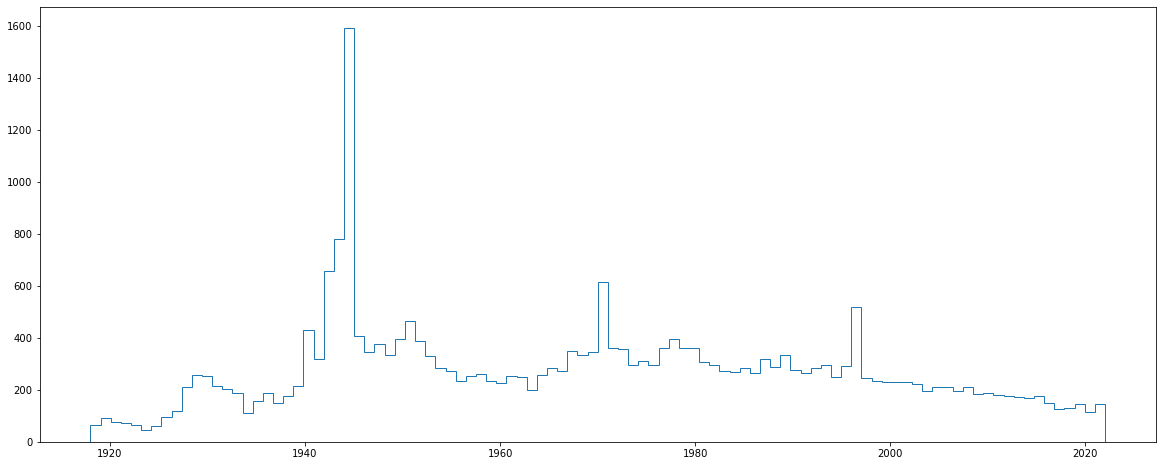

In [208]:
plt.figure(figsize=(20, 8))
plt.hist(df_crash['Date'].dt.year, bins = 100, histtype = 'step');

For personal interest, let's check all crashes in last 100 years. 

During the WWII, a lot more aircraft crashes.

In [209]:
# filter to only commercial flights
df_comm_crash = df_crash[df_crash['Flight type'] == 'Scheduled Revenue Flight']

In [210]:
# Missing value percentage
df_comm_crash.isna().sum()/ df_crash.shape[0] * 100

Date                0.000000
Aircraft            0.000000
Operator            0.000000
Flight phase        0.368514
Flight type         0.000000
Crash site          0.084758
Crash location      0.018426
Country             0.000000
Region              0.000000
Total fatalities    0.000000
Circumstances       0.007370
Crash cause         0.000000
survive             0.000000
dtype: float64

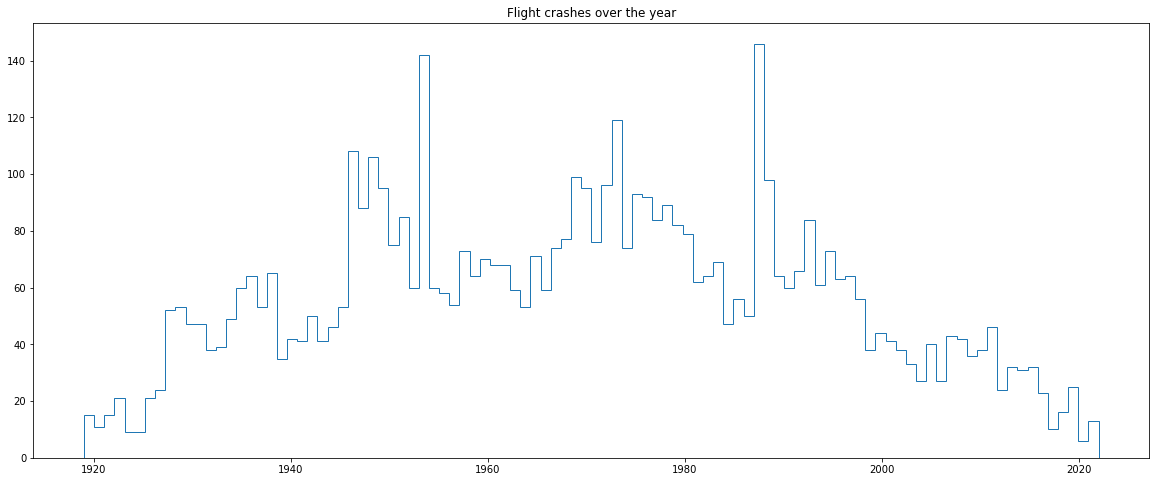

In [212]:
plt.figure(figsize=(20, 8))
plt.hist(df_comm_crash['Date'].dt.year, bins = 100, histtype = 'step');
plt.title('Flight crashes over the year');

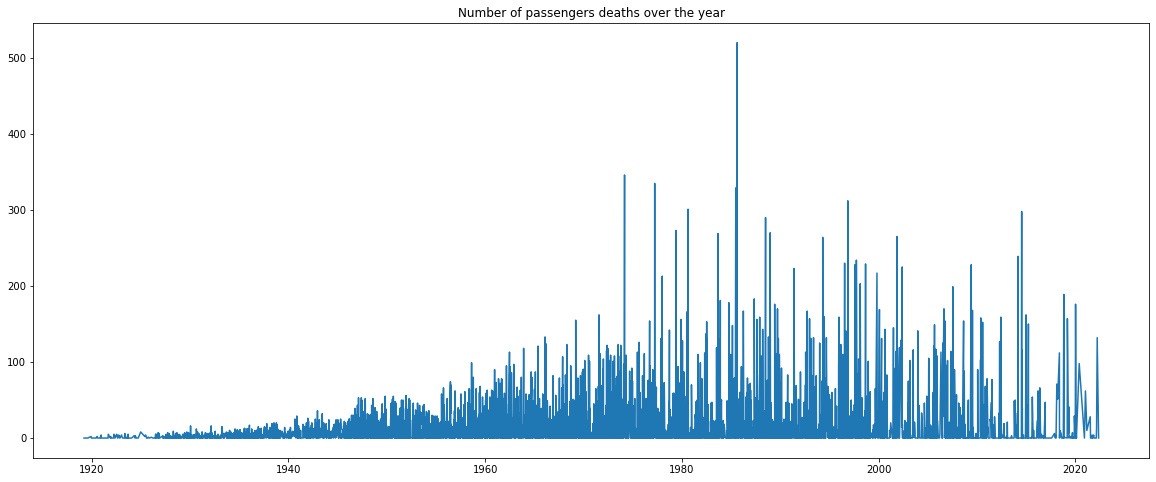

In [213]:
plt.figure(figsize=(20, 8))
plt.plot(df_comm_crash['Date'], df_comm_crash['Total fatalities'])
plt.title('Number of passengers deaths over the year');

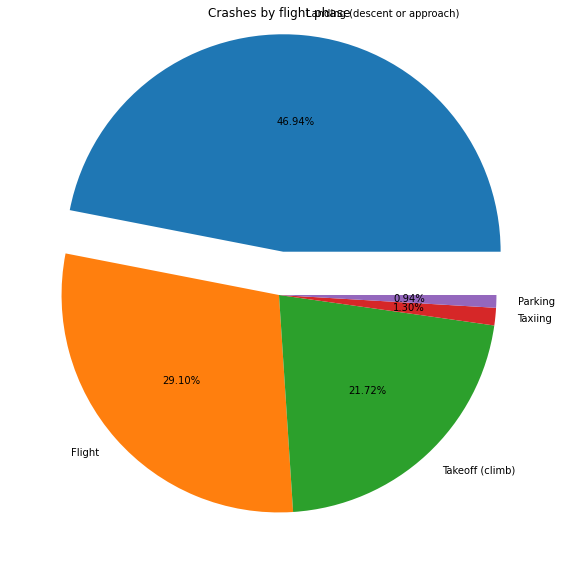

In [214]:
flight_phase = pd.DataFrame(df_comm_crash['Flight phase'].value_counts())

plt.figure(figsize=(10, 10))
plt.pie(flight_phase['Flight phase'], labels = flight_phase.index, explode = [0.2, 0, 0, 0, 0], autopct = '%1.2f%%')
plt.title('Crashes by flight phase');

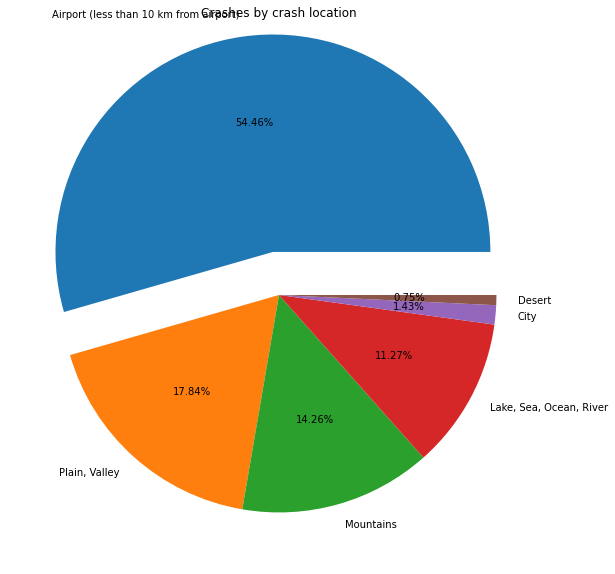

In [215]:
crash_location = pd.DataFrame(df_comm_crash['Crash site'].value_counts())

plt.figure(figsize=(10, 10))
plt.pie(crash_location['Crash site'], labels = crash_location.index, explode = [0.2, 0, 0, 0, 0, 0], autopct = '%1.2f%%')
plt.title('Crashes by crash location');

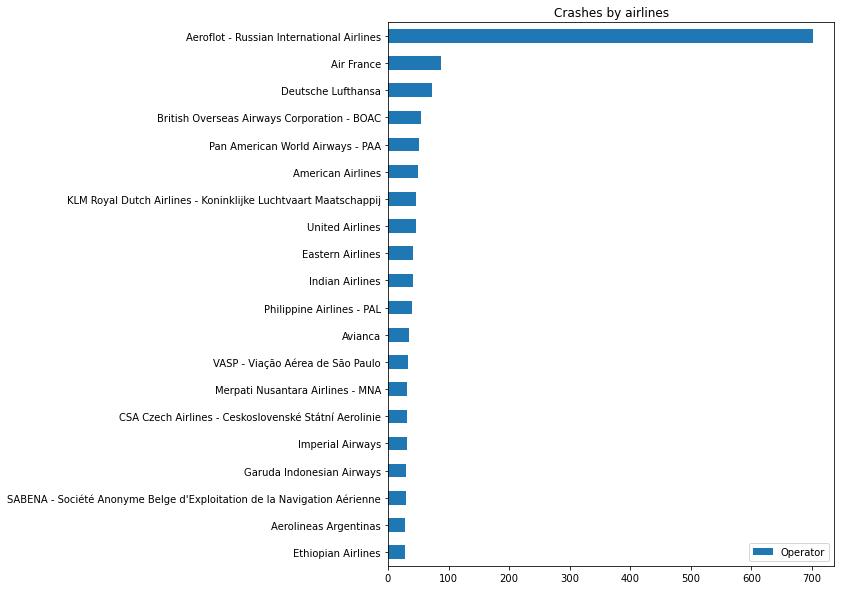

In [216]:
pd.DataFrame(df_comm_crash['Operator'].value_counts()).head(20).plot(kind = 'barh', figsize = (8, 10)).invert_yaxis()
plt.title('Crashes by airlines');

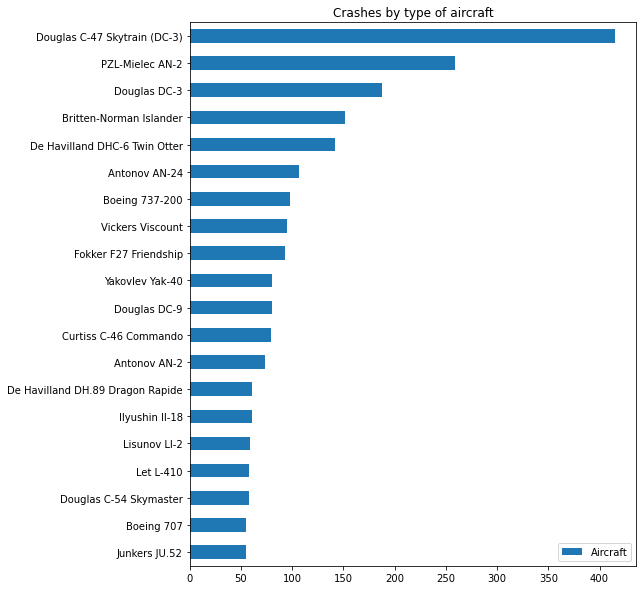

In [217]:
aircraft = pd.DataFrame(df_comm_crash['Aircraft'].value_counts()).head(20).plot(kind = 'barh', figsize = (8, 10)).invert_yaxis()
plt.title('Crashes by type of aircraft');

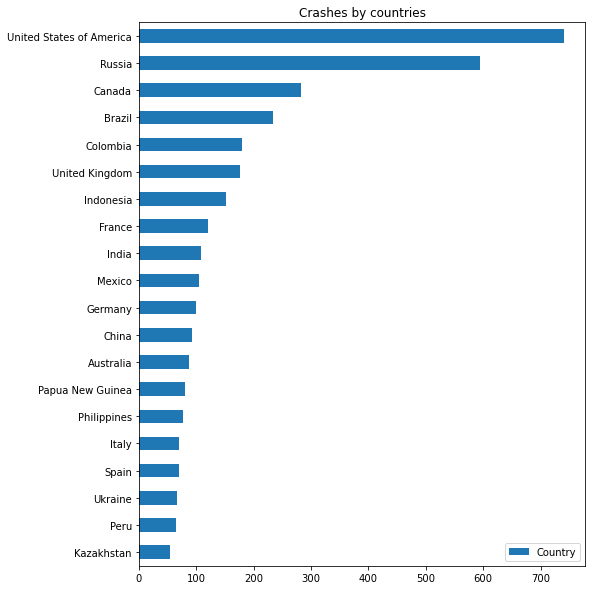

In [218]:
country = pd.DataFrame(df_comm_crash['Country'].value_counts()).head(20).plot(kind = 'barh', figsize = (8, 10)).invert_yaxis()
plt.title('Crashes by countries');

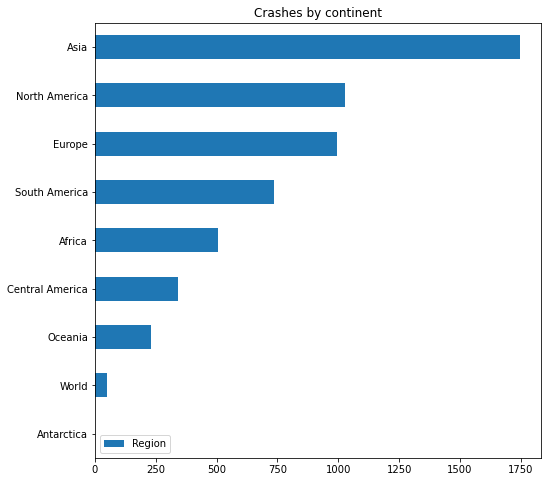

In [219]:
continent = pd.DataFrame(df_comm_crash['Region'].value_counts()).head(20).plot(kind = 'barh', figsize = (8, 8)).invert_yaxis()
plt.title('Crashes by continent');

### Modeling

In [112]:
df_comm_crash.shape

(5633, 13)

In [113]:
df_comm_crash.isna().sum()

Date                  0
Aircraft              0
Operator              0
Flight phase        100
Flight type           0
Crash site           23
Crash location        5
Country               0
Region                0
Total fatalities      0
Circumstances         2
Crash cause           0
survive               0
dtype: int64

In [114]:
df_comm_crash.head()

,Date,Aircraft,Operator,Flight phase,Flight type,Crash site,Crash location,Country,Region,Total fatalities,Circumstances,Crash cause,survive
31,1919-03-23,Unknown,Private French,Flight,Scheduled Revenue Flight,"Plain, Valley",Bordeaux Gironde,France,Europe,0,"In flight, the crew encountered engine problem...",Technical failure,1
32,1919-04-07,Unknown,Private French,Landing (descent or approach),Scheduled Revenue Flight,"Plain, Valley",France All France,France,Europe,0,Crashed in unknow circumstances somewhere in F...,Technical failure,1
49,1919-05-31,Blackburn R.T.1 Kangaroo,Grahame-White Aviation,Takeoff (climb),Scheduled Revenue Flight,Airport (less than 10 km from airport),Hendon Middlesex,United Kingdom,Europe,0,"Shortly after takeoff, during initial climb, t...",Technical failure,1
66,1919-08-15,Armstrong Whitworth F.K.8,London %26 Provincial Aviation,Flight,Scheduled Revenue Flight,"Plain, Valley",Great Yarmouth Norfolk,United Kingdom,Europe,0,The aircraft crashed in unknown circumstances ...,Unknown,1
82,1919-10-02,De Havilland DH.4,Aircraft Transport %26 Travel - AT%26T,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),Newcastle Tyne and Wear,United Kingdom,Europe,1,"On final approach to Newcastle, the engine los...",Technical failure,1


In [115]:
# Only keep the year of the crashes
df_comm_crash['Time'] = df_comm_crash['Date'].dt.year
# Remove unnecessary columns
df_comm_crash = df_comm_crash.drop(columns = ['Date', 'Circumstances', 'Crash location', 'Flight type', 'Country', 'Region'])

/var/folders/qb/44_9hw1s49d2hp61r3y2hmwm0000gn/T/ipykernel_38299/2341942218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comm_crash['Time'] = df_comm_crash['Date'].dt.year


In [116]:
df_comm_crash = df_comm_crash.reset_index(drop = True)
df_comm_crash.head()

,Aircraft,Operator,Flight phase,Crash site,Total fatalities,Crash cause,survive,Time
0,Unknown,Private French,Flight,"Plain, Valley",0,Technical failure,1,1919
1,Unknown,Private French,Landing (descent or approach),"Plain, Valley",0,Technical failure,1,1919
2,Blackburn R.T.1 Kangaroo,Grahame-White Aviation,Takeoff (climb),Airport (less than 10 km from airport),0,Technical failure,1,1919
3,Armstrong Whitworth F.K.8,London %26 Provincial Aviation,Flight,"Plain, Valley",0,Unknown,1,1919
4,De Havilland DH.4,Aircraft Transport %26 Travel - AT%26T,Landing (descent or approach),Airport (less than 10 km from airport),1,Technical failure,1,1919


#### X and Y Split (shuffle = True)

In [117]:
X = df_comm_crash.drop(columns = ['survive'])
y = df_comm_crash['survive']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [119]:
X_train.shape, X_test.shape

((4224, 7), (1409, 7))

### Baseline

In [133]:
y.value_counts(normalize = True)

1    0.705663
0    0.294337
Name: survive, dtype: float64

#### Deal with Missing Value

In [120]:
si = SimpleImputer(strategy = 'most_frequent')

In [121]:
si.fit(X_train)
X_train_fill = si.transform(X_train)
X_train_fill = pd.DataFrame(X_train_fill, columns = X_train.columns)

In [122]:
X_test_fill = si.transform(X_test)
X_test_fill = pd.DataFrame(X_test_fill, columns = si.feature_names_in_)

In [123]:
X_train_fill.isna().sum().sum(), X_test_fill.isna().sum().sum()

(0, 0)

In [124]:
ohe = OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore', sparse = False)

In [125]:
encoder = make_column_transformer(
    (ohe, ['Aircraft', 'Operator', 'Flight phase', 'Crash site', 'Crash cause']),
    remainder = 'passthrough',
    verbose_feature_names_out = False
)

In [126]:
X_train_enc = encoder.fit_transform(X_train_fill)
X_train_enc = pd.DataFrame(X_train_enc, columns = encoder.get_feature_names_out())

In [127]:
X_test_enc = encoder.transform(X_test_fill)
X_test_enc = pd.DataFrame(X_test_enc, columns = encoder.get_feature_names_out())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [128]:
X_train_enc.shape, X_test_enc.shape

((4224, 1943), (1409, 1943))

#### Logistic Regression

In [129]:
log = LogisticRegression(max_iter = 10000)

In [130]:
log.fit(X_train_enc, y_train)

LogisticRegression(max_iter=10000)

In [131]:
log.score(X_train_enc, y_train), log.score(X_test_enc, y_test)

(0.8624526515151515, 0.794889992902768)

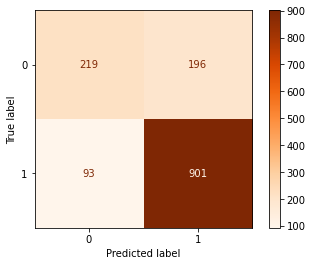

In [132]:
ConfusionMatrixDisplay.from_estimator(log, X_test_enc, y_test, cmap = 'Oranges');

#### X and Y Split (shuffle = False)

In [134]:
X1 = df_comm_crash.drop(columns = ['survive'])
y1 = df_comm_crash['survive']

In [135]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state = 42, shuffle = False)

In [136]:
si = SimpleImputer(strategy = 'most_frequent')

In [137]:
si.fit(X1_train)
X1_train_fill = si.transform(X1_train)
X1_train_fill = pd.DataFrame(X1_train_fill, columns = X_train.columns)

In [138]:
X1_test_fill = si.transform(X1_test)
X1_test_fill = pd.DataFrame(X1_test_fill, columns = si.feature_names_in_)

In [139]:
ohe = OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore', sparse = False)

In [140]:
encoder = make_column_transformer(
    (ohe, ['Aircraft', 'Operator', 'Flight phase', 'Crash site', 'Crash cause']),
    remainder = 'passthrough',
    verbose_feature_names_out = False
)

In [141]:
X1_train_enc = encoder.fit_transform(X1_train_fill)
X1_train_enc = pd.DataFrame(X1_train_enc, columns = encoder.get_feature_names_out())

In [142]:
X1_test_enc = encoder.transform(X1_test_fill)
X1_test_enc = pd.DataFrame(X1_test_enc, columns = encoder.get_feature_names_out())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [143]:
log = LogisticRegression(max_iter = 10000)
log.fit(X1_train_enc, y1_train)

LogisticRegression(max_iter=10000)

In [144]:
log.score(X1_train_enc, y1_train), log.score(X1_test_enc, y1_test)

(0.8392518939393939, 0.8616039744499645)

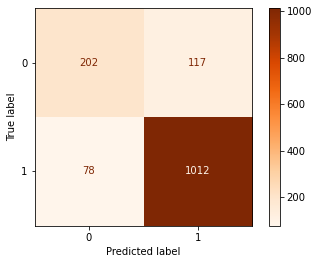

In [145]:
ConfusionMatrixDisplay.from_estimator(log, X1_test_enc, y1_test, cmap = 'Oranges');

Better accuracy when choosing split data by shuffle = False, this might because the number of crashes reduced in recent years. 

#### KNN Model

In [146]:
knn = KNeighborsClassifier()

In [147]:
knn.fit(X_train_enc, y_train)

KNeighborsClassifier()

In [148]:
knn.score(X_train_enc, y_train), knn.score(X_test_enc, y_test)

(0.8761837121212122, 0.8346344925479063)

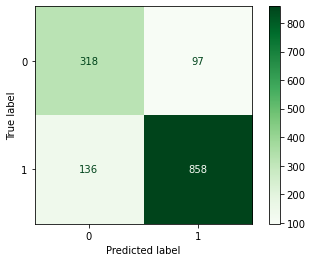

In [149]:
ConfusionMatrixDisplay.from_estimator(knn, X_test_enc, y_test, cmap = 'Greens');

In [150]:
knn.fit(X1_train_enc, y1_train)

KNeighborsClassifier()

In [151]:
knn.score(X1_train_enc, y1_train), knn.score(X1_test_enc, y1_test)

(0.8813920454545454, 0.8289567068843151)

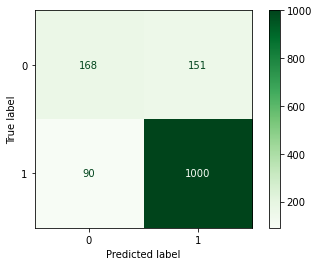

In [152]:
ConfusionMatrixDisplay.from_estimator(knn, X1_test_enc, y1_test, cmap = 'Greens');

#### Random Forest

In [154]:
RFC = RandomForestClassifier()

In [155]:
RFC.fit(X_train_enc, y_train)

RandomForestClassifier()

In [156]:
RFC.score(X_train_enc, y_train), RFC.score(X_test_enc, y_test)

(0.9997632575757576, 0.843860894251242)

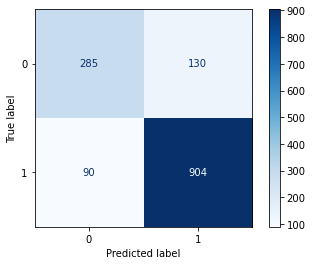

In [158]:
ConfusionMatrixDisplay.from_estimator(RFC, X_test_enc, y_test, cmap = 'Blues');

In [159]:
RFC.fit(X1_train_enc, y1_train)

RandomForestClassifier()

In [160]:
RFC.score(X1_train_enc, y1_train), RFC.score(X1_test_enc, y1_test)

(1.0, 0.8857345635202271)

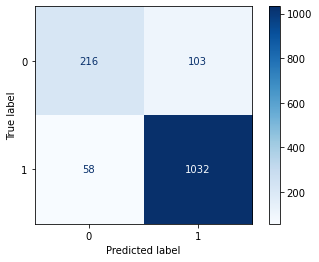

In [161]:
ConfusionMatrixDisplay.from_estimator(RFC, X1_test_enc, y1_test, cmap = 'Blues');

All models beat the baseline model. Random Forest had the best performance. 

### Dealing with Imbalanced Class Data

In [167]:
pipe1 = make_pipeline(RandomOverSampler(), LogisticRegression(max_iter = 10000))

In [168]:
pipe1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'randomoversampler', 'logisticregression', 'randomoversampler__random_state', 'randomoversampler__sampling_strategy', 'randomoversampler__shrinkage', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [171]:
param_grid1 = {
    'randomoversampler__sampling_strategy': [0.25, 0.5, 0.75, 1], 
    'logisticregression__C': [0.1, 0.5, 1.0, 1.5]
             }

In [172]:
gs1 = GridSearchCV(pipe1, param_grid = param_grid1, n_jobs = -1)

In [174]:
gs1.fit(X_train_enc, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/opt/anaconda3

GridSearchCV(estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1.0, 1.5],
                         'randomoversampler__sampling_strategy': [0.25, 0.5,
                                                                  0.75, 1]})

In [175]:
gs1.best_params_

{'logisticregression__C': 0.1, 'randomoversampler__sampling_strategy': 0.75}

In [176]:
gs1.score(X_train_enc, y_train), gs1.score(X_test_enc, y_test)

(0.8359375, 0.8026969481902059)

In [177]:
gs1.fit(X1_train_enc, y1_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/opt/anaconda3

GridSearchCV(estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1.0, 1.5],
                         'randomoversampler__sampling_strategy': [0.25, 0.5,
                                                                  0.75, 1]})

In [178]:
gs1.best_params_

{'logisticregression__C': 0.1, 'randomoversampler__sampling_strategy': 0.75}

In [180]:
gs1.score(X1_train_enc, y1_train), gs1.score(X1_test_enc, y1_test)

(0.8241003787878788, 0.8601845280340668)

The imbalanced strategy did not help much on predicting accuracy.

The following model took too much time to run, so I dropped. 

In [181]:
pipe2 = make_pipeline(RandomOverSampler(), RandomForestClassifier())

In [182]:
pipe2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'randomoversampler', 'randomforestclassifier', 'randomoversampler__random_state', 'randomoversampler__sampling_strategy', 'randomoversampler__shrinkage', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [183]:
param_grid2 = {
    'randomoversampler__sampling_strategy': [0.25, 0.5, 0.75, 1],  
    'randomforestclassifier__n_estimators': [100, 150, 200], 
    'randomforestclassifier__max_depth': [5, 7, 10, 12, 15], 
    'randomforestclassifier__min_samples_split': [2, 3, 5, 7]
             }

In [184]:
gs2 = GridSearchCV(pipe2, param_grid = param_grid2, n_jobs = -1)

In [185]:
gs2.fit(X_train_enc, y_train)

Process LokyProcess-9:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 446, in _process_worker
    del call_item
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
gs2.best_params_

In [ ]:
gs1.score(X1_train_enc, y1_train), gs1.score(X1_test_enc, y1_test)